In [7]:
import pandas as pd
import glob
import csv
import sys
csv.field_size_limit(2147483647)

file_path = "datasets/*.csv"  # Adjust to your dataset folder
file_list = glob.glob(file_path)

df_list = []

for file in file_list:
    try:
        df = pd.read_csv(file, encoding="utf-8", on_bad_lines="skip", engine="python")  
        df_list.append(df)
    except Exception as e:
        print(f"❌ Error reading {file}: {e}")

df = pd.concat(df_list, ignore_index=True)
print(f"✅ Loaded {len(file_list)} CSV files with {df.shape[0]} total samples.")

✅ Loaded 6 CSV files with 187336 total samples.


In [8]:
chunks = []
for file in file_list:
    try:
        for chunk in pd.read_csv(file, encoding="utf-8", on_bad_lines="skip", engine="python", chunksize=10000):
            chunks.append(chunk)
    except Exception as e:
        print(f"❌ Error reading {file}: {e}")

df = pd.concat(chunks, ignore_index=True)
print(f"✅ Successfully loaded CSVs with {df.shape[0]} samples.")

✅ Successfully loaded CSVs with 187336 samples.


In [9]:
for file in file_list:
    try:
        df = pd.read_csv(file, encoding="utf-8",)  # Read only first 5 rows
        print(f"📂 {file} Columns: {df.columns.tolist()}")
    except Exception as e:
        print(f"❌ Error in {file}: {e}")

📂 datasets\Assassin.csv Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
📂 datasets\CEAS-08.csv Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
📂 datasets\Enron.csv Columns: ['subject', 'body', 'label']
📂 datasets\Ling.csv Columns: ['subject', 'body', 'label']
❌ Error in datasets\TREC-05.csv: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

📂 datasets\TREC-07.csv Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']


In [10]:
df.to_csv("cleaned_file123.csv", encoding="utf-8", index=False)

In [11]:
import pandas as pd

# Load dataset
df = pd.read_csv("cleaned_file123.csv")

# Count phishing (1) and legitimate (0) emails
phishing_count = df[df['label'] == 1].shape[0]
legit_count = df[df['label'] == 0].shape[0]
print(f"Phishing Emails: {phishing_count}, Legitimate Emails: {legit_count}")

# Balance dataset by undersampling phishing emails
df_phishing = df[df['label'] == 1].sample(legit_count, random_state=42)  # Randomly pick same as legit count
df_legit = df[df['label'] == 0]  # Keep all legitimate emails

# Merge balanced dataset
df_balanced = pd.concat([df_phishing, df_legit])
print(f"✅ New Balanced Dataset: {df_balanced.shape[0]} rows")

# Save the balanced dataset
df_balanced.to_csv("balanced_cleaned.csv", index=False)


Phishing Emails: 29399, Legitimate Emails: 24358
✅ New Balanced Dataset: 48716 rows


PermissionError: [Errno 13] Permission denied: 'balanced_cleaned.csv'

In [12]:
df = pd.read_csv("balanced_cleaned.csv")

# Count phishing (1) and legitimate (0) emails
phishing_count = df[df['label'] == 1].shape[0]
legit_count = df[df['label'] == 0].shape[0]
print(f"Phishing Emails: {phishing_count}, Legitimate Emails: {legit_count}")

Phishing Emails: 24358, Legitimate Emails: 24358


In [13]:
import re
df = pd.read_csv("balanced_cleaned.csv")

# Function to extract URLs
def extract_urls(text):
    urls = re.findall(r'http[s]?://\S+', text)  # Find all URLs
    return " ".join(urls) if urls else "no_url"  # Return "no_url" if none found

# Apply URL extraction
df['urls'] = df['body'].apply(extract_urls)

# Balance dataset using SMOTE
X = df[['subject', 'body', 'urls']]  # Features
y = df['label']  # Labels

phishing_count = df[df['label'] == 1].shape[0]
legit_count = df[df['label'] == 0].shape[0]
print(f"Phishing Emails: {phishing_count}, Legitimate Emails: {legit_count}")

Phishing Emails: 24358, Legitimate Emails: 24358


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from urllib.parse import urlparse

# TF-IDF Vectorization for Email Text
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df_balanced['body'])
df_balanced['urls'] = df_balanced['urls'].astype(str)

# Function to extract domain from URLs
def extract_domain(url):
    if url == "no_url":
        return "no_domain"
    return urlparse(url).netloc  # Extract domain from URL

df_balanced['domain'] = df_balanced['urls'].apply(extract_domain)

# Convert Domain Feature to Numeric (One-Hot Encoding)
domain_vectorized = pd.get_dummies(df_balanced['domain'])

# Merge All Features
import numpy as np
X_final = np.hstack((X_text.toarray(), domain_vectorized.to_numpy()))
y_final = df_balanced['label'].values

print(f"✅ Final feature shape: {X_final.shape}")

✅ Final feature shape: (48716, 5001)


In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, stratify=y_final, random_state=42)

# Train XGBoost Model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, learning_rate=0.1)
xgb.fit(X_train, y_train)

# Predictions
y_pred = xgb.predict(X_test)

# Evaluation Metrics
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"✅ Precision: {precision_score(y_test, y_pred):.4f}")
print(f"✅ Recall: {recall_score(y_test, y_pred):.4f}")
print(f"✅ F1 Score: {f1_score(y_test, y_pred):.4f}")

c:\Users\Abhay Rana\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.9907
✅ Precision: 0.9874
✅ Recall: 0.9940
✅ F1 Score: 0.9907


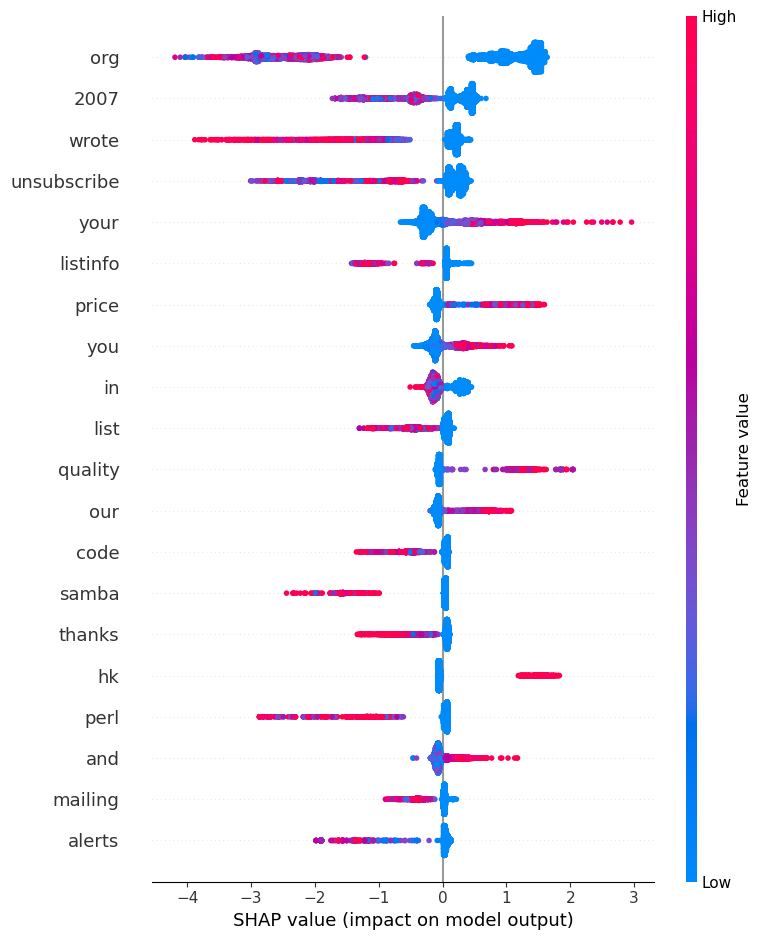

In [16]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, feature_names=vectorizer.get_feature_names_out())


In [24]:


# Predict on Training & Test Data
train_pred = xgb.predict(X_train)
test_pred = xgb.predict(X_test)

# Compute Accuracy
train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print(f"✅ Training Accuracy: {train_acc:.4f}")
print(f"✅ Validation Accuracy: {test_acc:.4f}")

# 🔹 If Training Accuracy >> Validation Accuracy (e.g., 98% vs. 75%), the model is overfitting!
if train_acc - test_acc > 0.1:
    print("⚠️ Warning: Possible Overfitting Detected!")
else:
    print("not")



✅ Training Accuracy: 0.9963
✅ Validation Accuracy: 0.9907
not


In [ ]:
import pickle

with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(xgb, f)

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [4]:
import gradio as gr
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

# Load XGBoost Model & TF-IDF Vectorizer
with open("pickle/xgboost_model.pkl", "rb") as f:
    model = pickle.load(f)

with open("pickle/tfidf_vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

# Function to clean email text
def clean_text(text):
    return str(text).lower().strip()

# Function to predict if an email is phishing
def predict_email(subject, body):
    email_text = subject + " " + body  # Combine subject & body
    email_text = clean_text(email_text)

    # Convert text to TF-IDF vector
    vectorized_text = vectorizer.transform([email_text]).toarray()

    # Predict using XGBoost model
    probability = model.predict_proba(vectorized_text)[0][1]  # Probability of phishing
    prediction = "🔴 Phishing Email" if probability > 0.5 else "🟢 Legitimate Email"
    
    return prediction, f"Phishing Probability: {probability:.2f}"

# Create Gradio UI
with gr.Blocks() as ui:
    gr.Markdown("## 🚀 Phishing Email Detection with XGBoost")
    
    with gr.Row():
        subject = gr.Textbox(label="📩 Email Subject")
        body = gr.Textbox(label="✉️ Email Body", lines=5)
    
    predict_btn = gr.Button("🔍 Detect")
    result = gr.Textbox(label="Result", interactive=False)
    probability = gr.Textbox(label="Phishing Probability", interactive=False)
    
    predict_btn.click(predict_email, inputs=[subject, body], outputs=[result, probability])

# Run Gradio App
ui.launch()


* Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


NameError: name 'X_train' is not defined

In [ ]:
import pickle
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

# Load dataset
df = pd.read_csv("balanced_cleaned.csv")

# Train TF-IDF Vectorizer and fix vocabulary
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['body']).toarray()
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Save model & vectorizer
with open("xgboost_model.pkl2", "wb") as f:
    pickle.dump(xgb_model, f)

with open("tfidf_vectorizer.pkl2", "wb") as f:
    pickle.dump(vectorizer, f)  # Save vectorizer with its vocabulary

print("✅ Model & vectorizer saved with consistent features!")


c:\Users\Abhay Rana\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:51:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model & vectorizer saved with consistent features!


In [1]:
import gradio as gr
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

# Load XGBoost Model & TF-IDF Vectorizer
with open("pickle/xgboost_model.pkl2", "rb") as f:
    model = pickle.load(f)

with open("pickle/tfidf_vectorizer.pkl2", "rb") as f:
    vectorizer = pickle.load(f)

# Function to clean email text
def clean_text(text):
    return str(text).lower().strip()

# Function to predict if an email is phishing
def predict_email(subject, body):
    email_text = subject + " " + body  # Combine subject & body
    email_text = clean_text(email_text)

    # Convert text to TF-IDF vector
    vectorized_text = vectorizer.transform([email_text]).toarray()

    # Predict using XGBoost model
    probability = model.predict_proba(vectorized_text)[0][1]  # Probability of phishing
    prediction = "🔴 Phishing Email" if probability > 0.5 else "🟢 Legitimate Email"
    
    return prediction, f"Phishing Probability: {probability:.2f}"

# Create Gradio UI
with gr.Blocks() as ui:
    gr.Markdown("## 🚀 Phishing Email Detection with XGBoost")
    
    with gr.Row():
        subject = gr.Textbox(label="📩 Email Subject")
        body = gr.Textbox(label="✉️ Email Body", lines=5)
    
    predict_btn = gr.Button("🔍 Detect")
    result = gr.Textbox(label="Result", interactive=False)
    probability = gr.Textbox(label="Phishing Probability", interactive=False)
    
    predict_btn.click(predict_email, inputs=[subject, body], outputs=[result, probability])

# Run Gradio App
ui.launch()



* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
